In [ ]:
import numpy as np
import pandas as pd

pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1. Introducción.

### 1.1. En primer lugar leémos los documentos csv que nos ha proporcionado la empresa y vemos que hay en cada uno de ellos.

In [ ]:
pd_sales=pd.read_csv('/content/drive/MyDrive/data_dsmarket/item_sales.csv',sep=',')
print("The shape of the sales datataframe is :", pd_sales.shape)

The shape of the sales datataframe is : (30490, 1920)


In [ ]:
pd_calendar=pd.read_csv('/content/drive/MyDrive/data_dsmarket/daily_calendar_with_events.csv',sep=',')
print("The shape of the calendar datataframe is :", pd_calendar.shape)

The shape of the calendar datataframe is : (1913, 5)


In [ ]:
pd_prices=pd.read_csv('/content/drive/MyDrive/data_dsmarket/item_prices.csv',sep=',')
print("The shape of the prices datataframe is :", pd_prices.shape)

The shape of the prices datataframe is : (6965706, 5)


### 1.2 Creamos nuestro dataframe para poder trabajar con él a través de estos 3 csv.

#### Primero ordenamos la tabla de sales, poniendo en vertical los días y ventas.

In [ ]:
lista_dias=[]
lista_descripcion=[]
for i in pd_sales:
    if i.startswith('d_'):
      lista_dias.append(i)
    else:
      lista_descripcion.append(i)

pd_sales = pd.melt(pd_sales, id_vars=lista_descripcion, value_vars=lista_dias, var_name='d', value_name='n_sales')

In [ ]:
pd_sales

,id,item,category,department,store,store_code,region,d,n_sales
0,ACCESORIES_1_001_NYC_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,d_1,0
1,ACCESORIES_1_002_NYC_1,ACCESORIES_1_002,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,d_1,0
2,ACCESORIES_1_003_NYC_1,ACCESORIES_1_003,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,d_1,0
3,ACCESORIES_1_004_NYC_1,ACCESORIES_1_004,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,d_1,0
4,ACCESORIES_1_005_NYC_1,ACCESORIES_1_005,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,d_1,0
...,...,...,...,...,...,...,...,...,...
58327365,SUPERMARKET_3_823_PHI_3,SUPERMARKET_3_823,SUPERMARKET,SUPERMARKET_3,Queen_Village,PHI_3,Philadelphia,d_1913,1
58327366,SUPERMARKET_3_824_PHI_3,SUPERMARKET_3_824,SUPERMARKET,SUPERMARKET_3,Queen_Village,PHI_3,Philadelphia,d_1913,0
58327367,SUPERMARKET_3_825_PHI_3,SUPERMARKET_3_825,SUPERMARKET,SUPERMARKET_3,Queen_Village,PHI_3,Philadelphia,d_1913,0
58327368,SUPERMARKET_3_826_PHI_3,SUPERMARKET_3_826,SUPERMARKET,SUPERMARKET_3,Queen_Village,PHI_3,Philadelphia,d_1913,3


#### Ordenamos y hacemos merge entre la tabla de calendar y tabla de prices.

In [ ]:
from datetime import datetime, timedelta
def weekyearnum(dt):
    return dt.strftime("%Y%W")

def myweeyearknum(dt):
    offsetdt = dt + timedelta(days=+2);
    return weekyearnum(offsetdt)

def weeknum(dt):
    return dt.isocalendar()[1]

def myweeknum(dt):
    offsetdt = dt + timedelta(days=+2);
    return weeknum(offsetdt)

In [ ]:
pd_calendar['date'] = pd.to_datetime(pd_calendar['date'], format = "%Y-%m-%d")

pd_calendar['yearweek'] = pd_calendar['date'].apply(lambda x: myweeyearknum(x))

In [ ]:
pd_calendar['yearweek'] = pd_calendar['yearweek'].astype(float)
pd_merge = pd.merge(pd_prices,pd_calendar[['date','d','yearweek']], how="left",
                   on="yearweek")

In [ ]:
pd_merge.shape

(46271877, 7)

#### Juntamos las tres tablas y nos quedamos con las columnas que queremos.

In [ ]:
pd_completo = pd.merge(pd_sales[['id','item','category','department','store_code','region','d','n_sales']],pd_merge[['item','category','store_code','yearweek','date','d','sell_price']], how="left",
                   on=['item','category','store_code','d'])

In [ ]:
pd_completo.isnull().sum()

,0
id,0
item,0
category,0
department,0
store_code,0
region,0
d,0
n_sales,0
yearweek,12299413
date,12299413


### 1.3 Manejo de los nulos.

#### Para evitar valores nulos en la columna date, los cuales se corresponden con días en los que no se vendió el producto, asiganmos cada día de la columna d a un día en concreto en orden.

In [ ]:
unique_d = pd_completo['d'].unique()

start_date = pd.to_datetime('2011-01-29')
dates = pd.date_range(start=start_date, periods=len(unique_d), freq='D')

date_mapping = pd.DataFrame({
    'd': unique_d,
    'date': dates
})

df = pd.merge(pd_completo[['id',
 'item',
 'category',
 'department',
 'store_code',
 'region',
 'd',
 'n_sales',
 'sell_price']], date_mapping, on='d', how='left')

#### Los nulos de la columna sell_price se corresponden con días donde no se vendió el producto, los rellenamos con un backfill donde se completa el valor nulo con el precio anterior de ese id.

In [ ]:
df['sell_price'] = df.groupby('id')['sell_price'].bfill()

In [ ]:
df.drop('d', axis = 1, inplace = True)

In [ ]:
df['revenue'] = df['sell_price']*df['n_sales']

In [ ]:
df.head()

,id,item,category,department,store_code,region,n_sales,sell_price,date,revenue
0,ACCESORIES_1_001_NYC_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,NYC_1,New York,0,12.74,2011-01-29,0.00
1,ACCESORIES_1_002_NYC_1,ACCESORIES_1_002,ACCESORIES,ACCESORIES_1,NYC_1,New York,0,5.28,2011-01-29,0.00
2,ACCESORIES_1_003_NYC_1,ACCESORIES_1_003,ACCESORIES,ACCESORIES_1,NYC_1,New York,0,3.95,2011-01-29,0.00
3,ACCESORIES_1_004_NYC_1,ACCESORIES_1_004,ACCESORIES,ACCESORIES_1,NYC_1,New York,0,5.77,2011-01-29,0.00
4,ACCESORIES_1_005_NYC_1,ACCESORIES_1_005,ACCESORIES,ACCESORIES_1,NYC_1,New York,0,3.96,2011-01-29,0.00


In [ ]:
df.isnull().sum()

,0
id,0
item,0
category,0
department,0
store_code,0
region,0
n_sales,0
sell_price,0
date,0
revenue,0


In [ ]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58327370 entries, 0 to 58327369
Data columns (total 10 columns):
 #   Column      Dtype         
---  ------      -----         
 0   id          object        
 1   item        object        
 2   category    object        
 3   department  object        
 4   store_code  object        
 5   region      object        
 6   n_sales     int64         
 7   sell_price  float64       
 8   date        datetime64[ns]
 9   revenue     float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(6)
memory usage: 4.3+ GB


#### Exportamos nuestro dataframe para trabajarlo en Power BI.

In [ ]:
df.describe()

,n_sales,sell_price,date,revenue
count,"58,327,370.00","58,327,370.00",58327370,"58,327,370.00"
mean,1.13,5.56,2013-09-11 00:00:00.000000768,3.96
min,0.00,0.01,2011-01-29 00:00:00,0.00
25%,0.00,2.62,2012-05-21 00:00:00,0.00
50%,0.00,4.18,2013-09-11 00:00:00,0.00
75%,1.00,7.18,2015-01-02 00:00:00,3.63
max,763.00,134.15,2016-04-24 00:00:00,"2,597.18"
std,3.87,4.55,NaN,11.83


In [ ]:
df.describe(include='object')

,id,item,category,department,store_code,region
count,58327370,58327370,58327370,58327370,58327370,58327370
unique,30490,3049,3,7,10,3
top,SUPERMARKET_3_827_PHI_3,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,NYC_1,New York
freq,1913,19130,27489810,15743990,5832737,23330948


In [ ]:
df.to_csv('df_ds_market.csv', sep=';', index=False)

## 2. Productos no vendidos en los últimos 28 días y limpieza del dataframe.

---



#### En primer lugar filtramos los últimos 28 días.

In [ ]:
df_last_month = df[df['date']>'2016-03-27']

#### Obtenemos una lista de los items que no se han vendido en ninguna de las 10 tiendas en los últimos 28 días. Con idea de pasar esta lista al departamento de ventas y valorar eliminar estos items del stock.

In [ ]:
productos_no_vendidos_ultimo_mes = df_last_month.groupby('id').filter(lambda x: x['n_sales'].sum() == 0)

In [ ]:
item_counts = productos_no_vendidos_ultimo_mes['item'].value_counts()

items_a_eliminar = item_counts[item_counts == 280].index

item_no_vendidos = productos_no_vendidos_ultimo_mes[productos_no_vendidos_ultimo_mes['item'].isin(items_a_eliminar)]

In [ ]:
item_no_vendidos['item'].unique()

array(['ACCESORIES_1_335', 'ACCESORIES_2_110', 'HOME_&_GARDEN_1_209',
       'HOME_&_GARDEN_1_366', 'HOME_&_GARDEN_2_158',
       'HOME_&_GARDEN_2_202', 'HOME_&_GARDEN_2_210',
       'HOME_&_GARDEN_2_456', 'HOME_&_GARDEN_2_502', 'SUPERMARKET_1_004',
       'SUPERMARKET_1_043', 'SUPERMARKET_1_120', 'SUPERMARKET_1_126',
       'SUPERMARKET_2_292', 'SUPERMARKET_3_002', 'SUPERMARKET_3_008',
       'SUPERMARKET_3_073', 'SUPERMARKET_3_077', 'SUPERMARKET_3_205',
       'SUPERMARKET_3_210', 'SUPERMARKET_3_271', 'SUPERMARKET_3_419',
       'SUPERMARKET_3_441', 'SUPERMARKET_3_444', 'SUPERMARKET_3_647'],
      dtype=object)

In [ ]:
lista_items_a_eliminar = item_no_vendidos['item'].unique()

#### Eliminamos esta lista de items de nuestro dataframe a partir de ahora, ya que ni en el cluster ni en el time series vamos a usar estos items.

In [ ]:
df_sin_no_vendidos_ultimo_mes = df.loc[~df['item'].isin(lista_items_a_eliminar)]

In [ ]:
# Una vez hemos logrado nuestro dataframe sin los productos que podemos considerar a eliminar de nuestro stock, podemos igualarlo a df para poder manejar mejor nuestro dataset.
df = df_sin_no_vendidos_ultimo_mes

## 3. Clustering.

In [ ]:
!pip install holidays

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 6.5 MB/s eta 0:00:00


In [ ]:
import warnings
warnings.filterwarnings("ignore")

import holidays

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import sklearn
from sklearn import set_config
set_config(transform_output = "pandas")

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.cluster import KMeans

### 3.1 Feature Engineering.

#### Empezamos por crear variables de tiempo, como variables de día, semana, mes o trimestre. Además, creamos las variables booleanas de holidays (para días que son festivos en EEUU) y weekend para identificar si es fin de semana.

In [ ]:
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

In [ ]:
#Creamos los festivos de EEUU.
us_holidays = holidays.UnitedStates(years=range(2011, 2016))

df['is_holiday'] = df['date'].isin(us_holidays)

In [ ]:
df['weekday_num'] = df['date'].dt.weekday

In [ ]:
df['trimestre'] = df['date'].dt.quarter

In [ ]:
df['year'] = df['date'].dt.year

In [ ]:
df['month'] = df['date'].dt.month

In [ ]:
df['is_weekend'] = df['date'].dt.weekday >= 5

#### Creamos columnas que nos vayan a ser útiles de cara al cluster a través de métricas como la media, el máximo, el mínimo, la suma o la desviación típica. Lo hacemos de varias columnas.

In [ ]:
# Métricas de cuando es día festivo.
df_holiday_true = df[df['is_holiday'] == True]

df_avg_sales_holiday = df_holiday_true.groupby('item').agg(
    total_sales_holiday = ('n_sales', 'sum'),
    max_sales_holiday = ('n_sales', 'max'),
    min_sales_holiday = ('n_sales', 'min'),
    mean_sales_holiday = ('n_sales', 'mean'),
    std_sales_holiday = ('n_sales', 'std')
)

In [ ]:
# Métricas de cuando es fin de semana.
df_finde_true = df[df['is_weekend'] == True]

df_avg_sales_weekend = df_finde_true.groupby('item').agg(
    total_sales_weekend = ('n_sales', 'sum'),
    max_sales_weekend = ('n_sales', 'max'),
    min_sales_weekend = ('n_sales', 'min'),
    mean_sales_weekend = ('n_sales', 'mean'),
    std_sales_weekend = ('n_sales', 'std')
)

In [ ]:
# Métricas según el trimestre, para ver si hay diferencias en la venta de items entre estaciones.
for i in range(1, 5):

    globals()[f'df_{i}_trimestre'] = df[df['trimestre'] == i]

    globals()[f'df_avg_sales_{i}_trimestre'] = globals()[f'df_{i}_trimestre'].groupby('item').agg(
      total_sales = ('n_sales', 'sum'),
      max_sales = ('n_sales', 'max'),
      min_sales = ('n_sales', 'min'),
      mean_sales = ('n_sales', 'mean'),
      std_sales = ('n_sales', 'std')
  ).rename(columns=lambda x: f"{x}_{i}_trimestre")


In [ ]:
df_avg_prices = df.groupby('item').agg(
    max_price = ('sell_price', 'max'),
    min_price = ('sell_price', 'min'),
    mean_price = ('sell_price', 'mean'),
    std_price = ('sell_price', 'std')
)

In [ ]:
df_avg_sales = df.groupby('item').agg(
    total_sales = ('n_sales', 'sum'),
    max_sales = ('n_sales', 'max'),
    min_sales = ('n_sales', 'min'),
    mean_sales = ('n_sales', 'mean'),
    std_sales = ('n_sales', 'std')
)

In [ ]:
df_avg_revenue = df.groupby('item').agg(
    total_revenue = ('revenue', 'sum'),
    max_revenue = ('revenue', 'max'),
    min_revenue = ('revenue', 'min'),
    mean_revenue = ('revenue', 'mean'),
    std_revenue = ('revenue', 'std')
)

In [ ]:
# Vemos la longitud de los dataframes creados de las métricas.
df_avg_revenue.shape

(3024, 5)

In [ ]:
lista_dataframes_avg = [var for var in globals() if isinstance(globals()[var], pd.DataFrame) and var.startswith('df_avg')]

#### Reducimos el dataframe original a través de los items, debido a que los cluster los queremos crear a partir de los items. Eliminamos de esta manera las fechas y las columnas que no nos vayan a servir para nuestro cluster.

In [ ]:
df_reducido = df.drop_duplicates(subset='item', keep='first').reset_index(drop=True)

In [ ]:
df_reducido.drop(['id',
 'store_code',
 'region',
 'n_sales',
 'sell_price',
 'date',
 'revenue',
 'is_holiday',
 'weekday_num',
 'trimestre',
 'year',
 'month',
 'is_weekend'], axis = 1, inplace = True)

In [ ]:
# Comprobamos que la longitud coincide con los otros dataframes creados.
df_reducido.shape

(3024, 3)

#### Juntamos el dataframe reducido con todas las métricas.

In [ ]:
for i in lista_dataframes_avg:
  df_reducido = pd.merge(df_reducido, globals()[i], on='item', how='left', left_index=False, right_index=False)

### 3.2 Data Preprocessing.

In [ ]:
df_reducido.set_index('item', inplace=True)

#### Dividimos las columnas numéricas que vamos a estandarizar y las categóricas que vamos a hacer OHE.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# Supongamos que tu DataFrame se llama df. Vamos a seleccionar las columnas que queremos usar para el clustering.
features = df_reducido.columns.tolist()
df_selected = df_reducido[features]

# Identificar columnas numéricas y categóricas
numeric_features = ['total_sales_holiday',
 'max_sales_holiday',
 'min_sales_holiday',
 'mean_sales_holiday',
 'std_sales_holiday',
 'total_sales_weekend',
 'max_sales_weekend',
 'min_sales_weekend',
 'mean_sales_weekend',
 'std_sales_weekend',
 'total_sales_1_trimestre',
 'max_sales_1_trimestre',
 'min_sales_1_trimestre',
 'mean_sales_1_trimestre',
 'std_sales_1_trimestre',
 'total_sales_2_trimestre',
 'max_sales_2_trimestre',
 'min_sales_2_trimestre',
 'mean_sales_2_trimestre',
 'std_sales_2_trimestre',
 'total_sales_3_trimestre',
 'max_sales_3_trimestre',
 'min_sales_3_trimestre',
 'mean_sales_3_trimestre',
 'std_sales_3_trimestre',
 'total_sales_4_trimestre',
 'max_sales_4_trimestre',
 'min_sales_4_trimestre',
 'mean_sales_4_trimestre',
 'std_sales_4_trimestre',
 'max_price',
 'min_price',
 'mean_price',
 'std_price',
 'total_sales',
 'max_sales',
 'min_sales',
 'mean_sales',
 'std_sales',
 'total_revenue',
 'max_revenue',
 'min_revenue',
 'mean_revenue',
 'std_revenue']

categorical_features = ['category',
 'department']


In [ ]:
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'  # Dejar otras columnas sin transformar
)

In [ ]:
kmeans_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ("Imputer", KNNImputer()),
    ("RobustScaler", RobustScaler(quantile_range = (0, 99.0))) # Puedes ajustar el número de clusters
])

### 3.3 Entrenamiento y creación de los clusters.

#### Empezamos entrenando nuestro modelo KMeans con varios clusters para ver cual es el adecuado a través de la elbow curve.

In [ ]:
# Entrenar el modelo
df_selected_scaled = kmeans_pipeline.fit_transform(df_selected)

In [ ]:
sse = {}

for k in range(2, 15):

    print(f"Fitting pipe with {k} clusters")

    clustering_model = KMeans(n_clusters = k)
    clustering_model.fit(df_selected_scaled)

    sse[k] = clustering_model.inertia_

Fitting pipe with 2 clusters
Fitting pipe with 3 clusters
Fitting pipe with 4 clusters
Fitting pipe with 5 clusters
Fitting pipe with 6 clusters
Fitting pipe with 7 clusters
Fitting pipe with 8 clusters
Fitting pipe with 9 clusters
Fitting pipe with 10 clusters
Fitting pipe with 11 clusters
Fitting pipe with 12 clusters
Fitting pipe with 13 clusters
Fitting pipe with 14 clusters


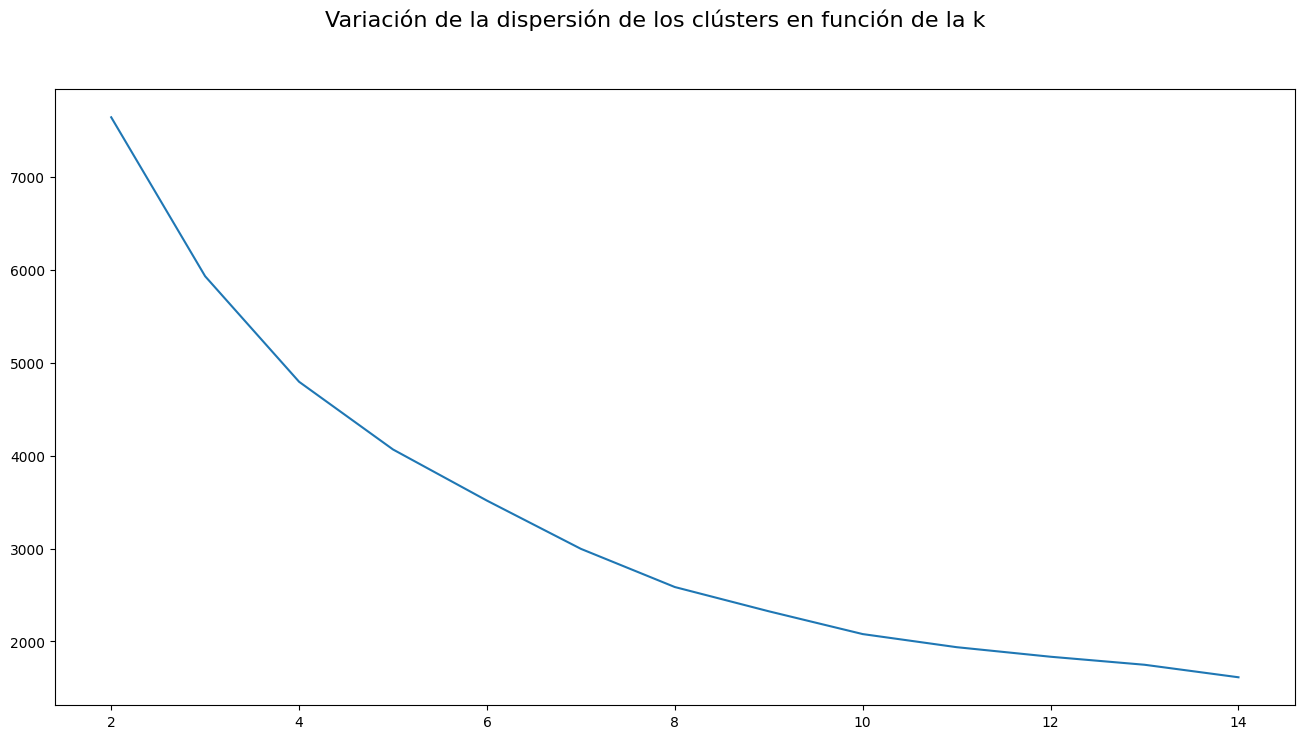

In [ ]:
fig = plt.figure(figsize = (16, 8))
ax = fig.add_subplot()

x_values = list(sse.keys())
y_values = list(sse.values())

ax.plot(x_values, y_values, label = "Inertia/dispersión de los clústers")
fig.suptitle("Variación de la dispersión de los clústers en función de la k", fontsize = 16);

#### Entrenamos nuestro modelo y vemos que el mejor cluster para nuestros datos es el de 4 grupos. Aunque también se hicieron entrenamientos con otros grupos como 3, 6 u 8 pero decidimos quedarnos con el de 4.

In [ ]:
kmeans_pipeline_final = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ("Imputer", KNNImputer()),
    ("RobustScaler", RobustScaler(quantile_range = (0, 99.0))),
    ("Clustering", KMeans(n_clusters = 4, random_state = 175))# Puedes ajustar el número de clusters
])

In [ ]:
kmeans_pipeline_final.fit(df_selected)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['total_sales_holiday',
                                                   'max_sales_holiday',
                                                   'min_sales_holiday',
                                                   'mean_sales_holiday',
                                                   'std_sales_holiday',
                                                   'total_sales_weekend',
                                                   'max_sales_weekend',
                                                   'min_sales_weekend',
                                                   'mean_sales_weekend',
                                                   'std_sales_weekend',
                                                   'total_sales_1_trimestre',
                                                   'max_...
                                                   'total_sales_4_trimestre',
                                                   'max_sales_4_trimestre',
                                                   'min_sales_4_trimestre',
                                                   'mean_sales_4_trimestre',
                                                   'std_sales_4_trimestre', ...]),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['category',
                                                   'department'])])),
                ('Imputer', KNNImputer()),
                ('RobustScaler', RobustScaler(quantile_range=(0, 99.0))),
                ('Clustering', KMeans(n_clusters=4, random_state=175))])

In [ ]:
df_selected_processed = kmeans_pipeline_final[:2].transform(df_selected)

In [ ]:
# Predecir los clusters y asignamos a la columna cluster.
df_selected['cluster'] = kmeans_pipeline_final.predict(df_selected)

#### Preparamos un dataframe para hacer un mapa de calor y analizar los datos.

In [ ]:
df_selected['n_items_cluster'] = df_selected.groupby('cluster')['cluster'].transform('count')

In [ ]:
df_to_print = df_selected[['max_price',
 'min_price',
 'mean_price',
 'std_price',
 'total_sales',
 'max_sales',
 'min_sales',
 'mean_sales',
 'std_sales',
 'total_revenue',
 'max_revenue',
 'min_revenue',
 'mean_revenue',
 'std_revenue',
 'total_sales_holiday',
 'max_sales_holiday',
 'min_sales_holiday',
 'mean_sales_holiday',
 'std_sales_holiday',
 'total_sales_weekend',
 'max_sales_weekend',
 'min_sales_weekend',
 'mean_sales_weekend',
 'std_sales_weekend',
 'total_sales_1_trimestre',
 'max_sales_1_trimestre',
 'min_sales_1_trimestre',
 'mean_sales_1_trimestre',
 'std_sales_1_trimestre',
 'total_sales_2_trimestre',
 'max_sales_2_trimestre',
 'min_sales_2_trimestre',
 'mean_sales_2_trimestre',
 'std_sales_2_trimestre',
 'total_sales_3_trimestre',
 'max_sales_3_trimestre',
 'min_sales_3_trimestre',
 'mean_sales_3_trimestre',
 'std_sales_3_trimestre',
 'total_sales_4_trimestre',
 'max_sales_4_trimestre',
 'min_sales_4_trimestre',
 'mean_sales_4_trimestre',
 'std_sales_4_trimestre',
 'n_items_cluster',
 'cluster']]

In [ ]:
df_to_print

,max_price,min_price,mean_price,std_price,total_sales,max_sales,min_sales,mean_sales,std_sales,total_revenue,max_revenue,min_revenue,mean_revenue,std_revenue,total_sales_holiday,max_sales_holiday,min_sales_holiday,mean_sales_holiday,std_sales_holiday,total_sales_weekend,max_sales_weekend,min_sales_weekend,mean_sales_weekend,std_sales_weekend,total_sales_1_trimestre,max_sales_1_trimestre,min_sales_1_trimestre,mean_sales_1_trimestre,std_sales_1_trimestre,total_sales_2_trimestre,max_sales_2_trimestre,min_sales_2_trimestre,mean_sales_2_trimestre,std_sales_2_trimestre,total_sales_3_trimestre,max_sales_3_trimestre,min_sales_3_trimestre,mean_sales_3_trimestre,std_sales_3_trimestre,total_sales_4_trimestre,max_sales_4_trimestre,min_sales_4_trimestre,mean_sales_4_trimestre,std_sales_4_trimestre,n_items_cluster,cluster
item,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ACCESORIES_1_001,12.74,6.65,11.47,0.74,4093,6,0,0.21,0.58,"45,037.76",65.91,0.00,2.35,6.34,116,4,0,0.22,0.61,1362,6,0,0.25,0.62,1163,6,0,0.23,0.60,780,6,0,0.16,0.51,951,6,0,0.21,0.55,1199,5,0,0.26,0.63,561,2
ACCESORIES_1_002,5.28,2.66,5.28,0.09,5059,11,0,0.26,0.59,"26,708.08",58.08,0.00,1.40,3.14,117,3,0,0.23,0.50,1777,11,0,0.32,0.65,1026,6,0,0.20,0.50,976,3,0,0.20,0.48,1293,6,0,0.28,0.57,1764,11,0,0.38,0.77,561,2
ACCESORIES_1_003,7.94,1.25,3.95,0.13,1435,6,0,0.08,0.32,"5,656.34",23.70,0.00,0.30,1.27,23,2,0,0.04,0.22,544,6,0,0.10,0.38,422,6,0,0.08,0.33,359,4,0,0.07,0.31,318,4,0,0.07,0.30,336,5,0,0.07,0.35,561,2
ACCESORIES_1_004,6.17,5.01,5.98,0.28,39175,25,0,2.05,2.67,"235,367.23",144.31,0.00,12.30,16.13,994,13,0,1.91,2.66,14098,25,0,2.57,3.06,10616,20,0,2.07,2.70,10099,25,0,2.11,2.78,8938,19,0,1.94,2.53,9522,19,0,2.07,2.64,561,2
ACCESORIES_1_005,4.10,2.00,3.84,0.22,14621,15,0,0.76,1.23,"55,667.12",49.48,0.00,2.91,4.63,386,8,0,0.74,1.22,5250,15,0,0.96,1.43,3493,12,0,0.68,1.15,2945,9,0,0.61,1.07,3712,11,0,0.81,1.25,4471,15,0,0.97,1.39,561,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SUPERMARKET_3_823,3.58,1.19,3.35,0.23,15388,25,0,0.80,1.71,"50,885.60",74.40,0.00,2.66,5.65,343,12,0,0.66,1.62,5363,19,0,0.98,2.00,4469,16,0,0.87,1.74,3006,14,0,0.63,1.49,3839,14,0,0.83,1.73,4074,25,0,0.89,1.87,1346,0
SUPERMARKET_3_824,3.22,2.40,3.03,0.26,8325,18,0,0.44,0.95,"25,416.59",57.89,0.00,1.33,2.93,200,7,0,0.38,0.89,2768,12,0,0.51,0.96,1918,10,0,0.37,0.84,2687,18,0,0.56,1.16,2161,10,0,0.47,0.92,1559,12,0,0.34,0.82,1346,0
SUPERMARKET_3_825,5.26,2.39,4.93,0.24,13526,20,0,0.71,1.20,"65,804.39",96.00,0.00,3.44,5.83,277,10,0,0.53,1.10,4707,20,0,0.86,1.40,4124,20,0,0.80,1.34,3258,10,0,0.68,1.04,3516,17,0,0.76,1.33,2628,8,0,0.57,1.03,1346,0


In [ ]:
ficha_df = pd.DataFrame()

In [ ]:
for i, col in enumerate(["n_items_cluster","mean_sales", "total_sales", "mean_revenue", "total_revenue", "mean_price","mean_sales_holiday","total_sales_holiday", "mean_sales_weekend","total_sales_weekend", "mean_sales_1_trimestre","total_sales_1_trimestre", "mean_sales_2_trimestre","total_sales_2_trimestre", "mean_sales_3_trimestre","total_sales_3_trimestre", "mean_sales_4_trimestre","total_sales_4_trimestre"]):
    resumen_data = df_to_print[["cluster", col]].groupby("cluster").describe().T[1:]
    ficha_df = pd.concat([ficha_df, resumen_data])

In [ ]:
# generamos nuestro multiindex
out_index = [
    "Nº_items",
    "Ventas_media",
    "Ventas_total",
    "Ganancias_media",
    "Ganancias_totales",
    "Precios",
    "Ventas_holiday_media",
    "Ventas_holiday_total",
    "Ventas_Fin_De_Semana_media",
    "Ventas_Fin_De_Semana_total",
    "Ventas_1_timestre_media",
    "Ventas_1_trimestre_total",
    "Ventas_2_timestre_media",
    "Ventas_2_trimestre_total",
    "Ventas_3_timestre_media",
    "Ventas_3_trimestre_total",
    "Ventas_4_timestre_media",
    "Ventas_4_trimestre_total"
]

inner_index = [
    "Cantidad de items",
    "N_ventas_media",
    "N_ventas_total",
    "Dinero_ganado_media",
    "Dinero_ganado_total",
    "Precio_vendido",
    "Ventas_holiday_media",
    "Ventas_holiday_total",
    "Ventas_Fin_De_Semana",
    "Ventas_Fin_De_Semana_media",
    "Ventas_1_timestre_media",
    "Ventas_1_trimestre_total",
    "Ventas_2_timestre_media",
    "Ventas_2_trimestre_total",
    "Ventas_3_timestre_media",
    "Ventas_3_trimestre_total",
    "Ventas_4_timestre_media",
    "Ventas_4_trimestre_total"
]

estadisticos = ["Media", "Desviación", "Mínimo", "Perc. 25", "Perc. 50", "Perc. 75", "Máximo"]

new_multi_index = []

for oi, ii, in zip(out_index, inner_index):
    for es in estadisticos:
        new_multi_index.append((oi, ii, es))

In [ ]:
def generate_multiindex(list_of_tuples, names):
    return pd.MultiIndex.from_tuples(list_of_tuples, names = names)

In [ ]:
names = ["Grupo Indicadores", "Indicador", "Estadístico"]
index_ficha = generate_multiindex(new_multi_index, names)
ficha_df.set_index(index_ficha, inplace = True)

In [ ]:
tamaño_clusters = df_to_print.groupby("cluster").size().to_frame().T
tamaño_clusters.set_index(generate_multiindex([("General", "Clúster", "Tamaño")] , names), inplace = True)

#### Printeamos nuestro mapa de calor y vemos por columnas como se comportan nuestros clusters, aunque posteriormente el análisis más a fondo lo veremos en Power BI.

In [ ]:
ficha_df.style.background_gradient(cmap = 'Blues', axis = 1)

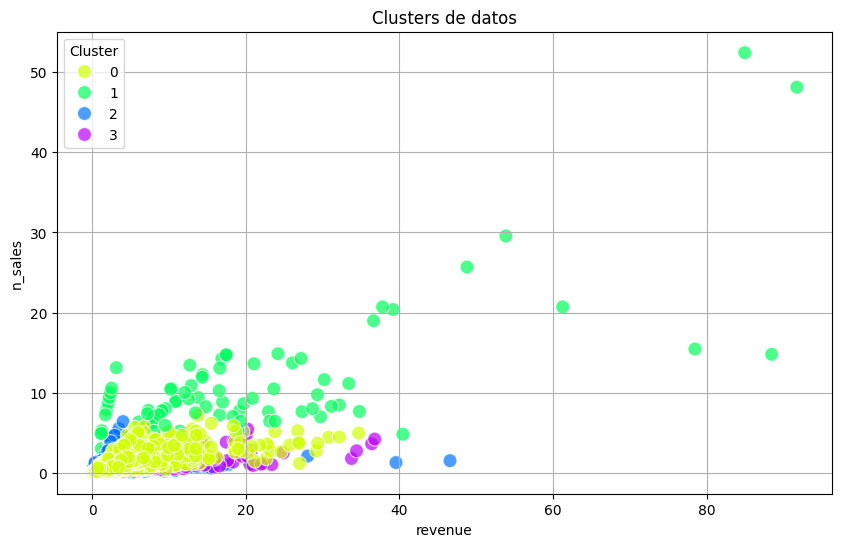

In [ ]:
palette = sns.color_palette("hsv", len(df_to_print['cluster'].unique()))

plt.figure(figsize=(10, 6))
sns.scatterplot(x='mean_revenue', y='mean_sales', hue='cluster', data=df_to_print, palette=palette, s=100, alpha=0.7)

plt.title('Clusters de datos')
plt.xlabel('revenue')
plt.ylabel('n_sales')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

#### Preparamos el dataframe reducido con los clusters para poder estudiarlo en Power BI.

In [ ]:
df_reducido['cluster'] = df_selected['cluster']

In [ ]:
df_reducido.reset_index(inplace=True)

In [ ]:
float_columns = df_reducido.select_dtypes(include=['float']).columns.tolist()

for i in float_columns:
  df_reducido[i] = df_reducido[i].round(2)
  df_reducido[i] = df_reducido[i].apply(lambda x: f'{x:.2f}'.replace('.', ','))

In [ ]:
df_reducido

,item,category,department,total_sales_holiday,max_sales_holiday,min_sales_holiday,mean_sales_holiday,std_sales_holiday,total_sales_weekend,max_sales_weekend,min_sales_weekend,mean_sales_weekend,std_sales_weekend,total_sales_1_trimestre,max_sales_1_trimestre,min_sales_1_trimestre,mean_sales_1_trimestre,std_sales_1_trimestre,total_sales_2_trimestre,max_sales_2_trimestre,min_sales_2_trimestre,mean_sales_2_trimestre,std_sales_2_trimestre,total_sales_3_trimestre,max_sales_3_trimestre,min_sales_3_trimestre,mean_sales_3_trimestre,std_sales_3_trimestre,total_sales_4_trimestre,max_sales_4_trimestre,min_sales_4_trimestre,mean_sales_4_trimestre,std_sales_4_trimestre,max_price,min_price,mean_price,std_price,total_sales,max_sales,min_sales,mean_sales,std_sales,total_revenue,max_revenue,min_revenue,mean_revenue,std_revenue,cluster
0,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,116,4,0,"0,22","0,61",1362,6,0,"0,25","0,62",1163,6,0,"0,23","0,60",780,6,0,"0,16","0,51",951,6,0,"0,21","0,55",1199,5,0,"0,26","0,63","12,74","6,65","11,47","0,74",4093,6,0,"0,21","0,58","45037,76","65,91","0,00","2,35","6,34",2
1,ACCESORIES_1_002,ACCESORIES,ACCESORIES_1,117,3,0,"0,22","0,50",1777,11,0,"0,32","0,65",1026,6,0,"0,20","0,50",976,3,0,"0,20","0,48",1293,6,0,"0,28","0,57",1764,11,0,"0,38","0,77","5,28","2,66","5,28","0,09",5059,11,0,"0,26","0,59","26708,08","58,08","0,00","1,40","3,14",2
2,ACCESORIES_1_003,ACCESORIES,ACCESORIES_1,23,2,0,"0,04","0,22",544,6,0,"0,10","0,38",422,6,0,"0,08","0,33",359,4,0,"0,07","0,31",318,4,0,"0,07","0,30",336,5,0,"0,07","0,35","7,94","1,25","3,95","0,13",1435,6,0,"0,08","0,32","5656,34","23,70","0,00","0,30","1,27",2
3,ACCESORIES_1_004,ACCESORIES,ACCESORIES_1,994,13,0,"1,91","2,66",14098,25,0,"2,57","3,06",10616,20,0,"2,07","2,70",10099,25,0,"2,11","2,78",8938,19,0,"1,94","2,53",9522,19,0,"2,07","2,64","6,17","5,01","5,98","0,28",39175,25,0,"2,05","2,67","235367,23","144,30","0,00","12,30","16,13",2
4,ACCESORIES_1_005,ACCESORIES,ACCESORIES_1,386,8,0,"0,74","1,22",5250,15,0,"0,96","1,43",3493,12,0,"0,68","1,15",2945,9,0,"0,61","1,07",3712,11,0,"0,81","1,25",4471,15,0,"0,97","1,39","4,10","2,00","3,84","0,22",14621,15,0,"0,76","1,23","55667,12","49,48","0,00","2,91","4,63",2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3019,SUPERMARKET_3_823,SUPERMARKET,SUPERMARKET_3,343,12,0,"0,66","1,62",5363,19,0,"0,98","2,00",4469,16,0,"0,87","1,74",3006,14,0,"0,63","1,49",3839,14,0,"0,83","1,73",4074,25,0,"0,89","1,87","3,58","1,19","3,35","0,23",15388,25,0,"0,80","1,71","50885,60","74,40","0,00","2,66","5,65",0
3020,SUPERMARKET_3_824,SUPERMARKET,SUPERMARKET_3,200,7,0,"0,38","0,89",2768,12,0,"0,51","0,96",1918,10,0,"0,37","0,84",2687,18,0,"0,56","1,16",2161,10,0,"0,47","0,92",1559,12,0,"0,34","0,82","3,22","2,40","3,03","0,26",8325,18,0,"0,44","0,95","25416,59","57,89","0,00","1,33","2,93",0
3021,SUPERMARKET_3_825,SUPERMARKET,SUPERMARKET_3,277,10,0,"0,53","1,10",4707,20,0,"0,86","1,40",4124,20,0,"0,80","1,34",3258,10,0,"0,68","1,04",3516,17,0,"0,76","1,33",2628,8,0,"0,57","1,03","5,26","2,39","4,93","0,24",13526,20,0,"0,71","1,20","65804,39","96,00","0,00","3,44","5,83",0
3022,SUPERMARKET_3_826,SUPERMARKET,SUPERMARKET_3,226,6,0,"0,43","0,95",3745,13,0,"0,68","1,30",2981,11,0,"0,58","1,19",3606,13,0,"0,75","1,35",2971,13,0,"0,65","1,26",2630,12,0,"0,57","1,17","1,54","1,20","1,54","0,01",12188,13,0,"0,64","1,25","18720,10","19,97","0,00","0,98","1,92",0


In [ ]:
# Exportamos el CSV en formato para visualizar en Power BI.
df_reducido.to_csv('df_4_cluster_final.csv', sep=';', index=False)

## 4. Time Series.

In [ ]:
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.9/153.9 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.9/190.9 MB 5.5 MB/s eta 0:00:00


In [ ]:
!pip install statsmodels

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 56.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.9/233.9 kB 18.2 MB/s eta 0:00:00


### Para el modelo de time series se vieron varias opciones como fue entrenar modelos ARIMA o PROPHET, pero finalmente vimos que la mejor manera de obtener unas mejores predicciones era con un modelo XGBOOST.

### Además se entreno el modelo de distintas maneras:
 - Primero se optó por un enfoque de entramiento por días, que era mucho más lento y precisaba de muchos recursos de RAM y memoria extras. Este primer enfoque resultó aportar predicciones más inexactas a nivel de semanas que era lo que no se interesaba para hacer nuestros stocks. Aunque no dejaba de ser un enfoque interesante de cara a algunos productos en concreto.

 - Segundo y finalmente se optó por un enfoque de agrupar por semanas la venta de productos y así optimizar recursos a la par de conseguir unas predicciones más realistas.

### 4.1 Data Preparation.

#### Empezamos por resamplear el dataframe por semanas, en la columna sell_price nos quedaremos con el último precio reciente de cada produtco, será el euqipo de ventas quien valore cambiar esos precios.

In [ ]:
df_to_resample = df.set_index('date')

In [ ]:
df_time_series_semanas = df_to_resample.groupby([pd.Grouper(freq='W'), 'id']).agg({
    'item': 'first',
    'category': 'first',
    'store_code': 'first',
    'region': 'first',
    'department': 'first',
    'n_sales': 'sum',
    'revenue': 'sum',
    'sell_price': 'first'
}).reset_index()

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder

import xgboost as xgb

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [ ]:
df_time_series_semanas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8285760 entries, 0 to 8285759
Data columns (total 10 columns):
 #   Column      Dtype         
---  ------      -----         
 0   date        datetime64[ns]
 1   id          object        
 2   item        object        
 3   category    object        
 4   store_code  object        
 5   region      object        
 6   department  object        
 7   n_sales     int64         
 8   revenue     float64       
 9   sell_price  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(6)
memory usage: 632.2+ MB


#### Creamos una función muy útil que nos permita crear 28 nuevos días o 4 semanas en este caso para poder hacer nuestras predicciones a futuro. Para ello mantendremos los últimos precios para cada producto y además rellenaremos las columnas de ventas con ceros.

In [ ]:
# Funcion para crear 28 nuevos días
def multistep_forecast(df):
  df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

  indice_28 = sorted(list(df["date"].unique()))[-4:]

  df_28 = df[df['date'].isin(indice_28)]

  df_28['date'] = df_28['date'].astype(str)

  lista_fechas_originales = df_28['date'].unique().tolist()

  new_day = df['date'].max() + pd.to_timedelta(1, unit='w')

  nuevo_rango_fechas = pd.date_range(start=new_day, periods=28, freq='W')

  date_strings = nuevo_rango_fechas.strftime('%Y-%m-%d').tolist()

  for valor_a, valor_b in zip(lista_fechas_originales, date_strings): #obtenemos los valores en cada iteración
	  df_28['date'] = np.where(df_28['date'] == valor_a, valor_b, df_28['date'])

  df_28['date'] = pd.to_datetime(df_28['date'], format='%Y-%m-%d')

  df_28['n_sales'] = 0

  df_final_time_series_forecast = pd.concat([df, df_28], axis=0).reset_index(drop=True)

  return df_final_time_series_forecast

In [ ]:
df_time_series = multistep_forecast(df_time_series_semanas)

### 4.2 Data Preprocessing.

#### Hacemos LabelEncoder de las columnas categóricas.

In [ ]:
from sklearn.preprocessing import LabelEncoder

lb = LabelEncoder()

lista_label = ['item', 'region', 'department', 'category', 'store_code']

for i in lista_label:
  df_time_series[i] = lb.fit_transform(df_time_series[i])

### 4.3 Feature engineering.

#### Empezamos por crear features relacionadas con el tiempor como son de año, trimestre o mes.

In [ ]:
def columnas_tiempo(df):
  df['trimestre'] = df['date'].dt.quarter
  df['year'] = df['date'].dt.year
  df['month'] = df['date'].dt.month

In [ ]:
columnas_tiempo(df_time_series)

In [ ]:
df_time_series.tail()

,date,id,item,category,store_code,region,department,n_sales,revenue,sell_price,trimestre,year,month
8406715,2016-05-22,SUPERMARKET_3_827_NYC_3,3023,2,5,1,6,0,45.60,1.20,2,2016,5
8406716,2016-05-22,SUPERMARKET_3_827_NYC_4,3023,2,6,1,6,0,26.40,1.20,2,2016,5
8406717,2016-05-22,SUPERMARKET_3_827_PHI_1,3023,2,7,2,6,0,18.00,1.20,2,2016,5
8406718,2016-05-22,SUPERMARKET_3_827_PHI_2,3023,2,8,2,6,0,14.40,1.20,2,2016,5
8406719,2016-05-22,SUPERMARKET_3_827_PHI_3,3023,2,9,2,6,0,0.00,1.20,2,2016,5


#### A través de una función creamos columnas que nos permitan mejorar nuestras predicciones, lo haremos usando las columnas de item, id, n_sales o revenue. Entre las nuevas columnas tenemos:
  - Medidas autorregresivas: a través de una lista de lags que son de 4, 8 y 12 semanas vamos a crear columnas que nos ayuden a usar la información del pasado para realizar nuestras predicciones.

  - Medias móviles: usando estos lags vamos a llevar a cabo unas medias de las últimas 4 y 12 semanas.


In [ ]:
lista_lags = [4,8,12]
def build_ts_vars(df, gb_list, target_column, agg_func, agg_func_name):

    assert "date" in df_time_series.columns.tolist(), "Date must be in df columns"

    new_name = "_".join(gb_list + [target_column] + [agg_func_name])

    gb_df_ = (
        df
        .set_index("date")
        .groupby(gb_list)
        .resample("W")[target_column]
        .apply(agg_func)
        .to_frame()
        .reset_index()
        .rename(
            columns = {
                target_column : new_name
            }
        )
    )

    for i in lista_lags:

      gb_df_[f"{new_name}_lag{i}"] = gb_df_.groupby(gb_list)[new_name].transform(
        lambda series: series.shift(i)
      )

    for i in lista_lags:
      gb_df_[f"{new_name}_roll_4_{i}"] = gb_df_.groupby(gb_list)[new_name].transform(
        lambda series: series.shift(i).rolling(window = 4).mean()
      )

      gb_df_[f"{new_name}_roll_12_{i}"] = gb_df_.groupby(gb_list)[new_name].transform(
        lambda series: series.shift(i).rolling(window = 12).mean()
      )


    print(f"Dropping columns that might cause target leakage {new_name}")
    gb_df_.drop(new_name, inplace = True, axis = 1)

    return gb_df_

GB_LIST = ["item"]
TARGET_COLUMN = "n_sales"
AGG_FUNC = np.sum
AGG_FUNC_NAME = "sum"

vars_ts_ = build_ts_vars(
    df = df_time_series,
    gb_list = GB_LIST,
    target_column = TARGET_COLUMN,
    agg_func = AGG_FUNC,
    agg_func_name =  AGG_FUNC_NAME

)


df_time_series = pd.merge(df_time_series, vars_ts_, on = ["date"] + GB_LIST, how = "left")

GB_LIST = ["id"]
TARGET_COLUMN = "revenue"
AGG_FUNC = np.sum
AGG_FUNC_NAME = "sum"

vars_ts_ = build_ts_vars(
    df = df_time_series,
    gb_list = GB_LIST,
    target_column = TARGET_COLUMN,
    agg_func = AGG_FUNC,
    agg_func_name =  AGG_FUNC_NAME

)

df_time_series = pd.merge(df_time_series, vars_ts_, on = ["date"] + GB_LIST, how = "left")

COLUMNS_TO_DROP = ['revenue']

df_time_series.drop(COLUMNS_TO_DROP, inplace = True, axis = 1)

Dropping columns that might cause target leakage item_n_sales_sum
Dropping columns that might cause target leakage id_revenue_sum


### 4.4 Entrenamiento de nuestro modelo XGBOOST.

Teniendo en cuenta que ya hemos añadido las 4 semanas a predecir dentro de nuestro dataframe, la partición para entrenar será de la siguiente manera:

  - Train: todos los valores menos las últimas 4 semanas de nuestro dataframe original.
  - Validación: los valores de las últimas 4 semanas de nuestro dataframe original.
  - Test: los valores de las 4 semanas a predicir.

  ### Después de hacer varias pruebas se escogen esos parámetros para el modelo.

In [ ]:
def train_test(df):
  df.set_index('id', inplace=True)

  train_index = sorted(list(df["date"].unique()))[:-8]
  valida_index = sorted(list(df["date"].unique()))[-8 :-4]
  test_index = sorted(list(df["date"].unique()))[-4:]
  X_train = df[df["date"].isin(train_index)].drop(['n_sales', "date"], axis=1)
  Y_train = df[df["date"].isin(train_index)]['n_sales']

  X_valida = df[df["date"].isin(valida_index)].drop(['n_sales', "date"], axis=1)
  Y_valida = df[df["date"].isin(valida_index)]['n_sales']

  X_test = df[df["date"].isin(test_index)].drop(['n_sales', "date"], axis=1)
  Y_test = df[df["date"].isin(test_index)]['n_sales']

  model = xgb.XGBRegressor(eval_metric = "rmse",
                            seed=175,
                            n_estimators=150,
                            early_stopping_rounds=15)

  model.fit(X_train, Y_train, eval_set = [(X_train, Y_train), (X_valida, Y_valida)], verbose=True)

  if "n_sales" in X_test.columns:
    X_test.drop("n_sales", axis = 1, inplace = True)

  Y_test_predict = model.predict(X_test)
  X_test["n_sales"] = Y_test_predict

  return Y_test_predict

In [ ]:
Y_test_predict = train_test(df_time_series)

[0]	validation_0-rmse:19.11988	validation_1-rmse:17.19692
[1]	validation_0-rmse:16.24824	validation_1-rmse:13.95943
[2]	validation_0-rmse:14.49899	validation_1-rmse:12.19564
[3]	validation_0-rmse:13.39723	validation_1-rmse:11.14197
[4]	validation_0-rmse:12.74583	validation_1-rmse:10.62435
[5]	validation_0-rmse:12.28256	validation_1-rmse:10.29646
[6]	validation_0-rmse:12.00647	validation_1-rmse:10.06806
[7]	validation_0-rmse:11.82504	validation_1-rmse:9.91766
[8]	validation_0-rmse:11.71142	validation_1-rmse:9.79262
[9]	validation_0-rmse:11.61246	validation_1-rmse:9.75124
[10]	validation_0-rmse:11.50752	validation_1-rmse:9.71637
[11]	validation_0-rmse:11.46782	validation_1-rmse:9.67816
[12]	validation_0-rmse:11.39940	validation_1-rmse:9.66497
[13]	validation_0-rmse:11.32517	validation_1-rmse:9.70401
[14]	validation_0-rmse:11.30833	validation_1-rmse:9.67649
[15]	validation_0-rmse:11.27023	validation_1-rmse:9.62937
[16]	validation_0-rmse:11.26403	validation_1-rmse:9.62849
[17]	validation_0

### 4.5 Creación del Dataframe con las predicciones.

In [ ]:
def dataframe_con_predicciones(df):
  train_index = sorted(list(df["date"].unique()))[:-8]
  valida_index = sorted(list(df["date"].unique()))[-8 :-4]
  test_index = sorted(list(df["date"].unique()))[-4:]
  df_para_cambiar_predict = df[df["date"].isin(test_index)]
  df_para_cambiar_predict['n_sales'] = Y_test_predict

  fecha_inicio = df['date'].max() - pd.to_timedelta(28, unit='d')
  fecha_fin = df['date'].max()

  mask = (df['date'] <= fecha_inicio) | (df['date'] > fecha_fin)

  df_filtrado = df[mask]

  df_filtrado_final = pd.concat([df_filtrado, df_para_cambiar_predict], ignore_index=False)

  df_filtrado_final.drop(['trimestre',
 'year',
 'month',
 'item_n_sales_sum_lag4',
 'item_n_sales_sum_lag8',
 'item_n_sales_sum_lag12',
 'item_n_sales_sum_roll_4_4',
 'item_n_sales_sum_roll_12_4',
 'item_n_sales_sum_roll_4_8',
 'item_n_sales_sum_roll_12_8',
 'item_n_sales_sum_roll_4_12',
 'item_n_sales_sum_roll_12_12',
 'id_revenue_sum_lag4',
 'id_revenue_sum_lag8',
 'id_revenue_sum_lag12',
 'id_revenue_sum_roll_4_4',
 'id_revenue_sum_roll_12_4',
 'id_revenue_sum_roll_4_8',
 'id_revenue_sum_roll_12_8',
 'id_revenue_sum_roll_4_12',
 'id_revenue_sum_roll_12_12'], axis=1, inplace=True)

  return df_filtrado_final

In [ ]:
df_con_predicciones = dataframe_con_predicciones(df_time_series)

df_con_predicciones.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8406720 entries, ACCESORIES_1_001_BOS_1 to SUPERMARKET_3_827_PHI_3
Data columns (total 8 columns):
 #   Column      Dtype         
---  ------      -----         
 0   date        datetime64[ns]
 1   item        int64         
 2   category    int64         
 3   store_code  int64         
 4   region      int64         
 5   department  int64         
 6   n_sales     float64       
 7   sell_price  float64       
dtypes: datetime64[ns](1), float64(2), int64(5)
memory usage: 577.2+ MB


#### Visualizamos la tendencia de nuestra gráfica con las predicciones, aunque el análisis a fondo lo veremos en Power BI.

In [ ]:
def plot_ts_acf_pacf(y, title):
    '''
    Plots the ts you pass and the acf and pacf.
    '''
    fig = plt.figure(figsize = (12, 10))
    ax1 = fig.subplots(1, 1)

    ax1.plot(y)

    plt.suptitle(t = title, fontsize = 20)

In [ ]:
y = df_con_predicciones.set_index("date").resample("W")["n_sales"].sum()

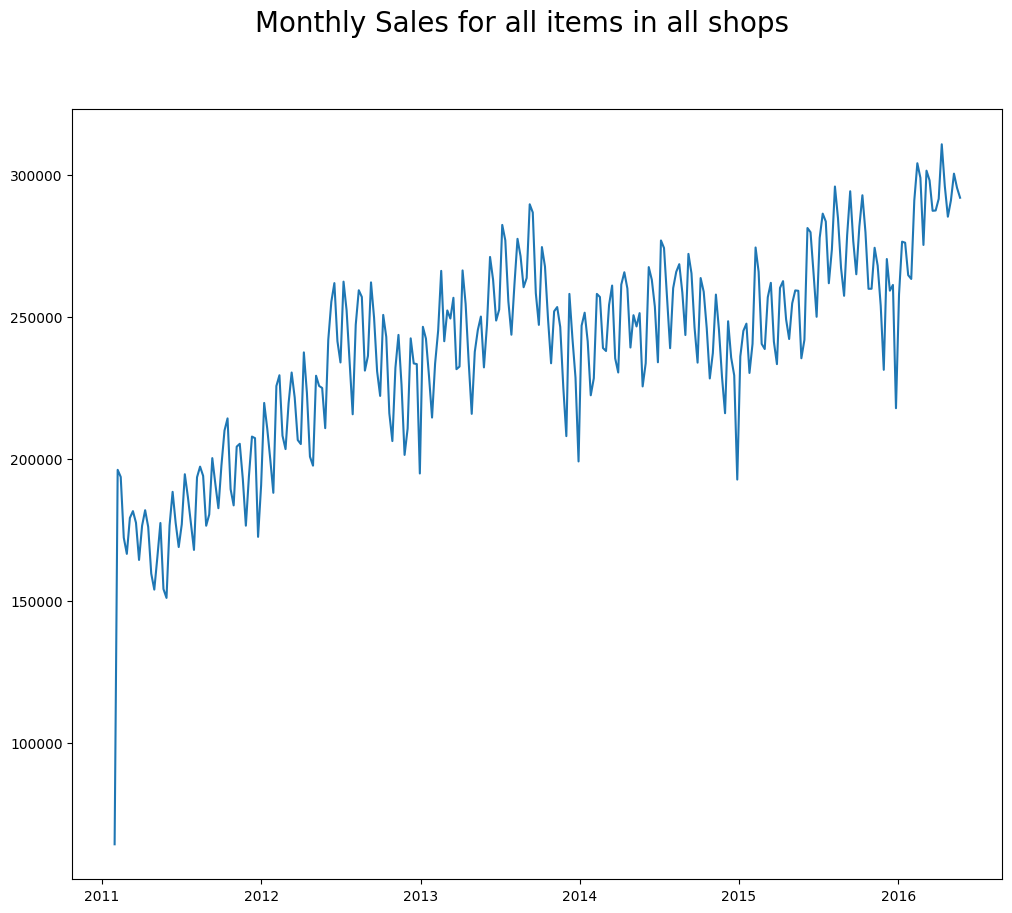

In [ ]:
plot_ts_acf_pacf(y = y, title = "Monthly Sales for all items in all shops");

In [ ]:
df_con_predicciones.reset_index(inplace=True)

In [ ]:
df_con_predicciones['revenue'] = df_con_predicciones['n_sales']*df_con_predicciones['sell_price']

In [ ]:
df_con_predicciones.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8406720 entries, 0 to 8406719
Data columns (total 10 columns):
 #   Column      Dtype         
---  ------      -----         
 0   id          object        
 1   date        datetime64[ns]
 2   item        int64         
 3   category    int64         
 4   store_code  int64         
 5   region      int64         
 6   department  int64         
 7   n_sales     float64       
 8   sell_price  float64       
 9   revenue     float64       
dtypes: datetime64[ns](1), float64(3), int64(5), object(1)
memory usage: 641.4+ MB


#### Destacar que este proceso de time series se puede volver a repetir desde el paso en el que se crean las 4 semanas a futuro, de ahí el nombre de multistep. Aunque realmente entrenar el modelo con datos que ya se han generado con el modelo y no con datos reales, suaviza muchos las predcciones. Sin embargo, para hacer las visualizaciones en Power Bi hemos utilizado el dataframe con las predicciones de 12 semanas. Nuestro modelo está enfocado a predecir a 4 semanas vista siempre que hayamos actualizado nuestros datos de ventas.

### 4.6 Preparación dataframe en formato para visualizar en Power BI.

Aquí tenemos las predicciones de 4 semanas, para nuestro Power Bi obtuvimos uno a 12 reptiendo nuestro modelo 3 veces.

In [ ]:
df_con_predicciones['id_2'] = df_con_predicciones['id'].str.replace(r'_(?=&_)|(?<=&)_', '', regex=True)

In [ ]:
df_con_predicciones.head()

,id,date,item,category,store_code,region,department,n_sales,sell_price,revenue,id_2
0,ACCESORIES_1_001_BOS_1,2011-01-30,0,0,0,0,0,0.00,12.74,0.00,ACCESORIES_1_001_BOS_1
1,ACCESORIES_1_001_BOS_2,2011-01-30,0,0,1,0,0,0.00,12.74,0.00,ACCESORIES_1_001_BOS_2
2,ACCESORIES_1_001_BOS_3,2011-01-30,0,0,2,0,0,0.00,11.46,0.00,ACCESORIES_1_001_BOS_3
3,ACCESORIES_1_001_NYC_1,2011-01-30,0,0,3,1,0,0.00,12.74,0.00,ACCESORIES_1_001_NYC_1
4,ACCESORIES_1_001_NYC_2,2011-01-30,0,0,4,1,0,0.00,10.99,0.00,ACCESORIES_1_001_NYC_2


In [ ]:
split_columns = df_con_predicciones['id_2'].str.split('_', expand = True)
split_columns

,0,1,2,3,4
0,ACCESORIES,1,001,BOS,1
1,ACCESORIES,1,001,BOS,2
2,ACCESORIES,1,001,BOS,3
3,ACCESORIES,1,001,NYC,1
4,ACCESORIES,1,001,NYC,2
...,...,...,...,...,...
8406715,SUPERMARKET,3,827,NYC,3
8406716,SUPERMARKET,3,827,NYC,4
8406717,SUPERMARKET,3,827,PHI,1
8406718,SUPERMARKET,3,827,PHI,2


In [ ]:
df_con_predicciones['item'] = split_columns[0] + '_' + split_columns[1] + '_' + split_columns[2]

df_con_predicciones['category'] = split_columns[0]

df_con_predicciones['store_code'] = split_columns[3] + '_' + split_columns[4]

df_con_predicciones['department'] = split_columns[0] + '_' + split_columns[1]

In [ ]:
df_con_predicciones['region'] = df_con_predicciones['region'].astype(object)

df_con_predicciones['region'] = np.where(df_con_predicciones['region'] == 0, 'Boston', df_con_predicciones['region'])

df_con_predicciones['region'] = np.where(df_con_predicciones['region'] == 1, 'New York', df_con_predicciones['region'])

df_con_predicciones['region'] = np.where(df_con_predicciones['region'] == 2, 'Philadelphia', df_con_predicciones['region'])

In [ ]:
df_con_predicciones['region'].unique()

array(['Boston', 'New York', 'Philadelphia'], dtype=object)

In [ ]:
df_con_predicciones.head()

,id,date,item,category,store_code,region,department,n_sales,sell_price,revenue,id_2
0,ACCESORIES_1_001_BOS_1,2011-01-30,ACCESORIES_1_001,ACCESORIES,BOS_1,Boston,ACCESORIES_1,0.00,12.74,0.00,ACCESORIES_1_001_BOS_1
1,ACCESORIES_1_001_BOS_2,2011-01-30,ACCESORIES_1_001,ACCESORIES,BOS_2,Boston,ACCESORIES_1,0.00,12.74,0.00,ACCESORIES_1_001_BOS_2
2,ACCESORIES_1_001_BOS_3,2011-01-30,ACCESORIES_1_001,ACCESORIES,BOS_3,Boston,ACCESORIES_1,0.00,11.46,0.00,ACCESORIES_1_001_BOS_3
3,ACCESORIES_1_001_NYC_1,2011-01-30,ACCESORIES_1_001,ACCESORIES,NYC_1,New York,ACCESORIES_1,0.00,12.74,0.00,ACCESORIES_1_001_NYC_1
4,ACCESORIES_1_001_NYC_2,2011-01-30,ACCESORIES_1_001,ACCESORIES,NYC_2,New York,ACCESORIES_1,0.00,10.99,0.00,ACCESORIES_1_001_NYC_2


In [ ]:
def redondeo_coma(df, lista):
  for i in lista:
    df[i] = df[i].round(2)
    df[i] = df[i].apply(lambda x: f'{x:.2f}'.replace('.', ','))

In [ ]:
lista_float = ['n_sales', 'revenue', 'sell_price']

In [ ]:
redondeo_coma(df_con_predicciones, lista_float)

In [ ]:
df_con_predicciones.drop('id_2', axis=1, inplace=True)

In [ ]:
df_con_predicciones.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8406720 entries, 0 to 8406719
Data columns (total 10 columns):
 #   Column      Dtype         
---  ------      -----         
 0   id          object        
 1   date        datetime64[ns]
 2   item        object        
 3   category    object        
 4   store_code  object        
 5   region      object        
 6   department  object        
 7   n_sales     object        
 8   sell_price  object        
 9   revenue     object        
dtypes: datetime64[ns](1), object(9)
memory usage: 641.4+ MB


#### Exportamos nuestro dataframe para trabajar con él.

In [ ]:
df_con_predicciones.to_csv('df_con_predicciones.csv', sep = ';', index=False)

In [ ]:
df_con_predicciones = pd.read_csv('df_con_predicciones.csv', sep = ';')

## 5. Stock.

### 5.1 Creación del csv del stock con las predicciones de las 4 primeras semanas.

In [ ]:
df_stock = df_con_predicciones[df_con_predicciones['date'] > '2016-04-24']

In [ ]:
df_stock.info()

<class 'pandas.core.frame.DataFrame'>
Index: 120960 entries, 8285760 to 8406719
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   id          120960 non-null  object
 1   date        120960 non-null  object
 2   item        120960 non-null  object
 3   category    120960 non-null  object
 4   store_code  120960 non-null  object
 5   region      120960 non-null  object
 6   department  120960 non-null  object
 7   n_sales     120960 non-null  object
 8   sell_price  120960 non-null  object
 9   revenue     120960 non-null  object
dtypes: object(10)
memory usage: 10.2+ MB


In [ ]:
df_stock.head()

,id,date,item,category,store_code,region,department,n_sales,sell_price,revenue
8285760,ACCESORIES_1_001_BOS_1,2016-05-01,ACCESORIES_1_001,ACCESORIES,BOS_1,Boston,ACCESORIES_1,"2,69","10,99","29,57"
8285761,ACCESORIES_1_001_BOS_2,2016-05-01,ACCESORIES_1_001,ACCESORIES,BOS_2,Boston,ACCESORIES_1,"3,75","10,99","41,22"
8285762,ACCESORIES_1_001_BOS_3,2016-05-01,ACCESORIES_1_001,ACCESORIES,BOS_3,Boston,ACCESORIES_1,"3,93","10,99","43,23"
8285763,ACCESORIES_1_001_NYC_1,2016-05-01,ACCESORIES_1_001,ACCESORIES,NYC_1,New York,ACCESORIES_1,"6,10","10,99","66,97"
8285764,ACCESORIES_1_001_NYC_2,2016-05-01,ACCESORIES_1_001,ACCESORIES,NYC_2,New York,ACCESORIES_1,"6,21","10,99","68,17"


### 5.2 Implantación del modelo EOQ.

#### El modelo EOQ (modelo de cantidad económica de pedido) es una herramienta muy utilizada para el control de inventario y el abastecimiento de tiendas. Este modelo nos permite hacer un buen control tanto en la optimización del tamaño de pedidos como en el stock de seguridad que tenemos que tener en cada una de nuestras tiendas en función de cada id. De hecho este modelo es muy útil a la hora de lidiar con productos en los que hay una alta variabilidad en el número de ventas, desde productos que se venden muy poco a otros que se venden asiduamente.

Para aplicar la fórmula en la que se basa este modelo tenemos que tener ciertas variables entre las que podemos encontrar:
  - Cálculo de venta promedio(D): en nuestro caso va a ser el valor de la columna df_stock['n_sales'].
  - Desviación estándar de la demanda del producto(σ): una nueva columna creada a continuación que muestre esta desviación, df_stock['std_desviation'].
  - Costo de realizar un pedido(S): una columna que exprese el costo de realizar un pedido por cada producto, en nuestro caso hemos escogido un 10% del sell_price, aunque el equipo de lógistica podría darnos una estimación al respecto. Así este variable sera df_stock['sell_price']*0.10.
  - Costo de mantenimiento de un producto(H): variable que corresponde a lo que le cuesta a la empresa mantener un producto en stock, elegimos un 5%, aunque como en el caso de la variable S, logística podría ajustar este valor. Corresponde está variable a df_stock['sell_price']*0.05.


In [ ]:
df_stock['sell_price'] = df_stock['sell_price'].str.replace(',','.')

In [ ]:
df_stock['sell_price'] = df_stock['sell_price'].astype(float)

In [ ]:
df_stock['n_sales'] = df_stock['n_sales'].str.replace(',','.')

In [ ]:
df_stock['n_sales'] = df_stock['n_sales'].astype(float)

In [ ]:
df_stock['n_sales'] = df_stock['n_sales'].apply(lambda x: 0 if x < 0 else x)

In [ ]:
std = df_stock.groupby('id')['n_sales'].std()

In [ ]:
df_stock['std_desviation'] = df_stock['id'].map(std)

#### Creamos también la variable week para hacer luego nuestra consultas más facilmente.

In [ ]:
df_stock['date'] = pd.to_datetime(df_stock['date'])

In [ ]:
df_stock['week']= df_stock['date'].dt.isocalendar().week

In [ ]:
df_stock.info()

<class 'pandas.core.frame.DataFrame'>
Index: 120960 entries, 8285760 to 8406719
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   id              120960 non-null  object        
 1   date            120960 non-null  datetime64[ns]
 2   item            120960 non-null  object        
 3   category        120960 non-null  object        
 4   store_code      120960 non-null  object        
 5   region          120960 non-null  object        
 6   department      120960 non-null  object        
 7   n_sales         120960 non-null  float64       
 8   sell_price      120960 non-null  float64       
 9   revenue         120960 non-null  object        
 10  std_desviation  120960 non-null  float64       
 11  week            120960 non-null  UInt32        
dtypes: UInt32(1), datetime64[ns](1), float64(3), object(7)
memory usage: 11.7+ MB


In [ ]:
df_stock['H'] = df_stock['sell_price'] * 0.05
df_stock['S'] = df_stock['sell_price'] * 0.10

#### 5.2.1 Cantidad económica de pedido(EOQ).
Emepezamos por calcular la cantidad económica de pedido(EOQ), que sería el número de unidades a la hora de hacer un pedido de uno de nuestros productos. En nuestro caso la variable D hay que ajustarla a 4 semanas multiplicando por 4. La fórmula sería, en dos pasos:
  1. D = D x 4.
  2. EOQ = √(2DS/H) ​

Guardamos el valor en la columna -> df_stock['n_productos_pedido'].

In [ ]:
df_stock['D_4'] = df_stock['n_sales'] * 4

df_stock['n_productos_pedido'] = np.sqrt((2 * df_stock['D_4'] * df_stock['S']) / df_stock['H'])

Calcular el Stock de Seguridad (SS) El Stock de Seguridad (SS) depende de la variabilidad en la demanda y el nivel de servicio deseado (probabilidad de no tener faltantes): S S = Z × σ × L SS=Z×σ× L ​ donde: Z = Factor de nivel de servicio (basado en la distribución normal, por ejemplo, 1.65 para un nivel de servicio del 95%). σ = Desviación estándar de la demanda semanal. L = Tiempo de reabastecimiento (lead time) en semanas.



#### 5.2.2 Stock de seguridad(SS).
Aquí vamos a calcular la cantidad de unidades en inventario usadas para mitigar la desviación de la demanda. Esto quiere decir que es el stock extra que se mantiene para enfrentar imprevistos relacionados a los cambios en la demanda o problemas con el abastecimiento por parte de los proveedores. Para ello necesitamos implementar las variables:
  - Z = factor de nivel de servicio, que ebn una distribución normal sería 1.65 y es el valor que vamos a utilizar.
  - L = tiempo de reabastecimiento, en nuestro caso 1 semana, o sea que 1.

Con esto la fórmula para calcular este stock será:
  - SS = Z x σ x L.

Guardamos el valor en la columna -> df_stock['stock_extra']

In [ ]:
Z = 1.65

df_stock['stock_extra'] = Z * df_stock['std_desviation'] * np.sqrt(1)

#### 5.2.3 Punto de Reorden(ROP).
representa el nivel de inventario en el cual se debe realizar un nuevo pedido para reabastecer el stock antes de que se agote. Su fórmula es:
  - ROP = (D x L) + SS.

Lo vamos a estimar como el stock preciso mínimo para no tener que hacer un pedido de ese producto.

Lo guardamos en la variable df_stock['stock_preciso']

In [ ]:
df_stock['stock_preciso'] = (df_stock['n_sales'] * 1) + df_stock['stock_extra']

In [ ]:
df_stock.head()

,id,date,item,category,store_code,region,department,n_sales,sell_price,revenue,std_desviation,week,H,S,D_4,n_productos_pedido,stock_extra,stock_preciso
8285760,ACCESORIES_1_001_BOS_1,2016-05-01,ACCESORIES_1_001,ACCESORIES,BOS_1,Boston,ACCESORIES_1,2.69,10.99,"29,57",0.29,17,0.55,1.10,10.76,6.56,0.48,3.17
8285761,ACCESORIES_1_001_BOS_2,2016-05-01,ACCESORIES_1_001,ACCESORIES,BOS_2,Boston,ACCESORIES_1,3.75,10.99,"41,22",0.32,17,0.55,1.10,15.00,7.75,0.52,4.27
8285762,ACCESORIES_1_001_BOS_3,2016-05-01,ACCESORIES_1_001,ACCESORIES,BOS_3,Boston,ACCESORIES_1,3.93,10.99,"43,23",0.23,17,0.55,1.10,15.72,7.93,0.38,4.31
8285763,ACCESORIES_1_001_NYC_1,2016-05-01,ACCESORIES_1_001,ACCESORIES,NYC_1,New York,ACCESORIES_1,6.10,10.99,"66,97",0.69,17,0.55,1.10,24.40,9.88,1.15,7.25
8285764,ACCESORIES_1_001_NYC_2,2016-05-01,ACCESORIES_1_001,ACCESORIES,NYC_2,New York,ACCESORIES_1,6.21,10.99,"68,17",0.65,17,0.55,1.10,24.84,9.97,1.07,7.28


#### Una vez creadas ya todas nuestras nuevas variables en las que basaremos nuestro stock, comentar que sería preciso ajustar las fórmulas en función del tipo de producto como pueden ser aquellos productos más perecederos.

In [ ]:
lista_redondeo = ['n_productos_pedido','n_sales', 'stock_extra', 'stock_preciso']
for i in lista_redondeo:
  df_stock[i] = np.ceil(df_stock[i])
  df_stock[i] = df_stock[i].astype(int)

In [ ]:
df_stock['week'] = df_stock['week'].astype(object)

In [ ]:
df_stock = df_stock[['id', 'week', 'n_sales', 'n_productos_pedido', 'stock_extra', 'stock_preciso']]

#### Todos esos productos donde el stock_preciso sea de 0, serán productos que los clientes podrán comprar bajo demanda.

In [ ]:
df_stock.describe()

,n_sales,n_productos_pedido,stock_extra,stock_preciso
count,"120,960.00","120,960.00","120,960.00","120,960.00"
mean,10.24,10.77,2.67,12.41
std,20.02,7.10,4.11,22.83
min,0.00,0.00,0.00,0.00
25%,3.00,6.00,1.00,3.00
50%,5.00,9.00,2.00,6.00
75%,10.00,13.00,3.00,13.00
max,705.00,107.00,175.00,705.00


In [ ]:
df_stock.describe(include='object')

,id,week
count,120960,120960
unique,30240,4
top,SUPERMARKET_3_824_BOS_1,17
freq,4,30240


#### Creamos nuestro documento final csv con el stock para las 4 semanas, con el que además usaremos para generar un API y consultar sus valores desde ella.

In [ ]:
df_stock.to_csv('df_stock.csv', sep = ';', index=False)